https://archive.ics.uci.edu/dataset/186/wine+quality

In [1]:
# set up Python
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from wvu.util import plot_roc
from scipy.stats import spearmanr
from rank_plotting_fns import build_line_frame
from plotnine import *

In [2]:
wine_quality_red = pd.read_csv('wine+quality/winequality-red.csv', sep=';')
wine_quality_red['is_red'] = True
wine_quality_white = pd.read_csv('wine+quality/winequality-white.csv', sep=';')
wine_quality_white['is_red'] = False
assert np.all(wine_quality_red.columns == wine_quality_white.columns)

In [3]:
wine_data = pd.concat([
    wine_quality_red.loc[:, [c for c in wine_quality_red.columns if c != 'quality']],
    wine_quality_white.loc[:, [c for c in wine_quality_white.columns if c != 'quality']],
], ignore_index=True)

wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,True
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,True
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,True
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,True
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,True
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,False
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,False
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,False
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,False


In [4]:
wine_data['is_red']

0        True
1        True
2        True
3        True
4        True
        ...  
6492    False
6493    False
6494    False
6495    False
6496    False
Name: is_red, Length: 6497, dtype: bool

In [5]:
for c in sorted(wine_data.columns):
    print(c)

alcohol
chlorides
citric acid
density
fixed acidity
free sulfur dioxide
is_red
pH
residual sugar
sulphates
total sulfur dioxide
volatile acidity


In [6]:
row = wine_data.loc[[6425], :].copy()
for i in range(5):
    row[f'posn_{i}'] = 0
row['posn_2'] = 1
row.transpose()

,6425
fixed acidity,6.0
volatile acidity,0.34
citric acid,0.29
residual sugar,6.1
chlorides,0.046
free sulfur dioxide,29.0
total sulfur dioxide,134.0
density,0.99462
pH,3.48
sulphates,0.57


In [7]:
wine_scores = pd.concat([
    wine_quality_red.loc[:, ['is_red', 'quality']],
    wine_quality_white.loc[:, ['is_red', 'quality']],
], ignore_index=True)

wine_scores

,is_red,quality
0,True,5
1,True,5
2,True,5
3,True,6
4,True,5
...,...,...
6492,False,6
6493,False,5
6494,False,6
6495,False,7


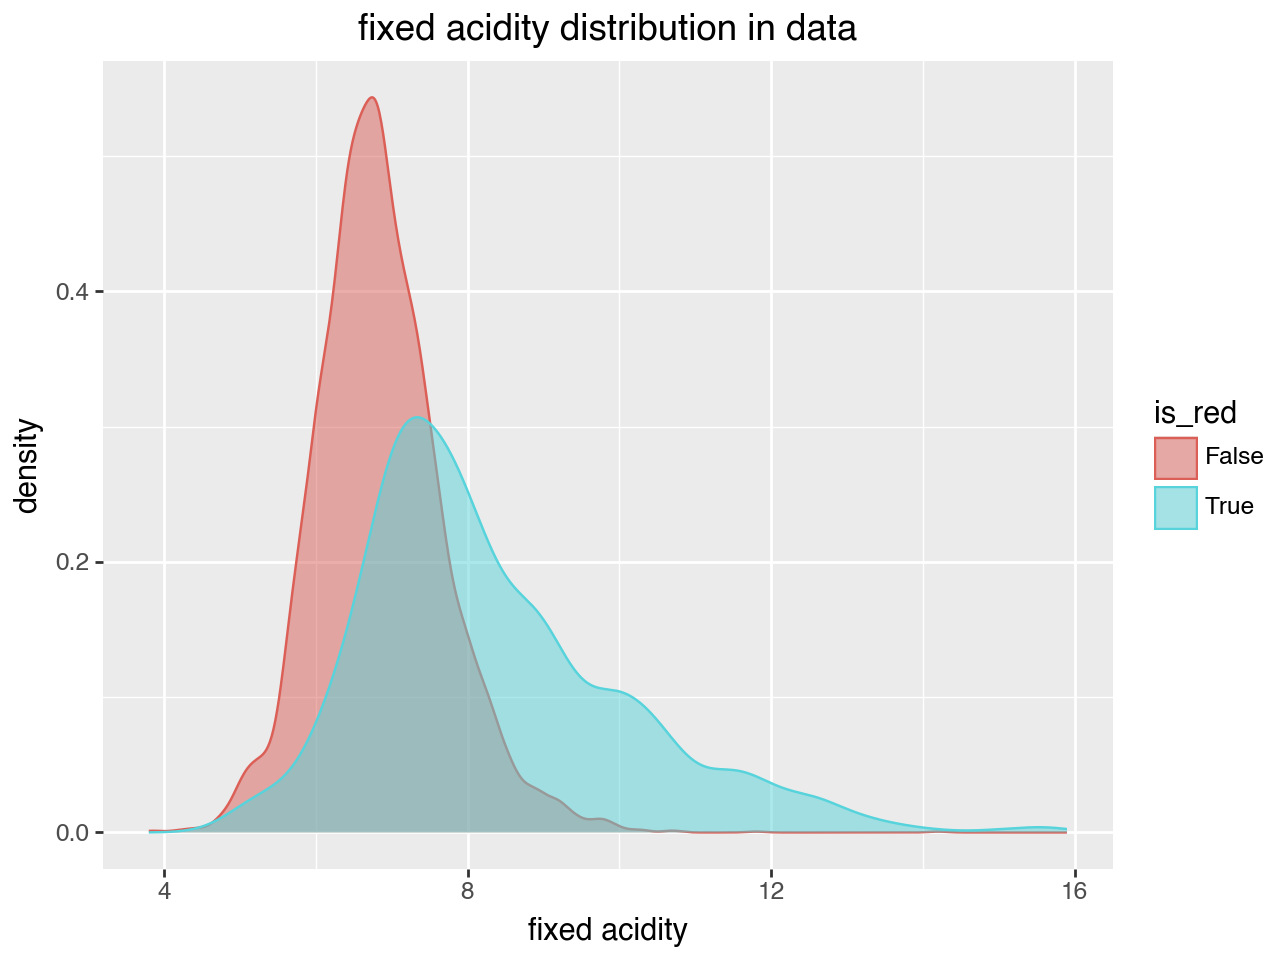

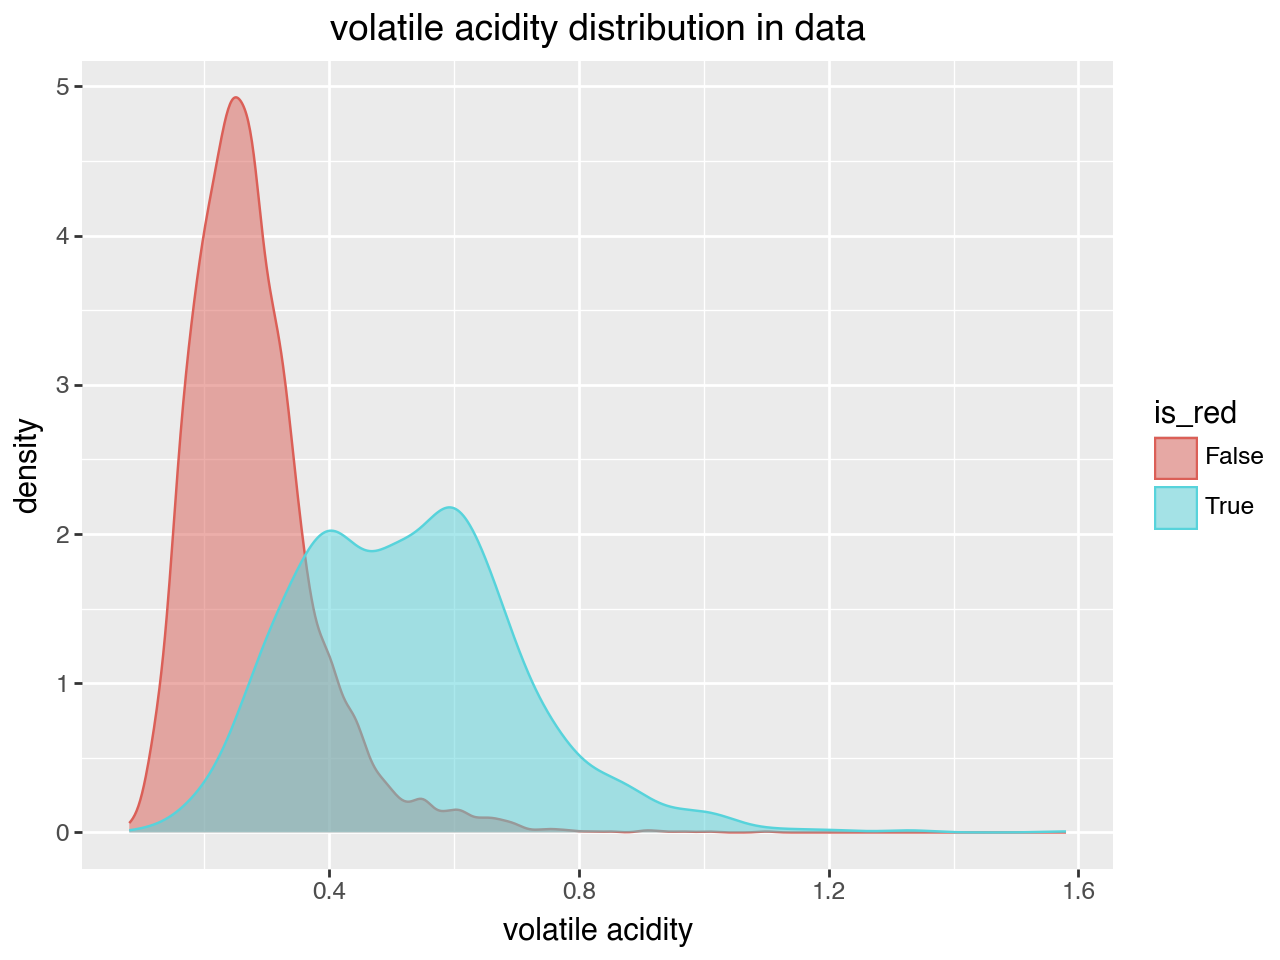

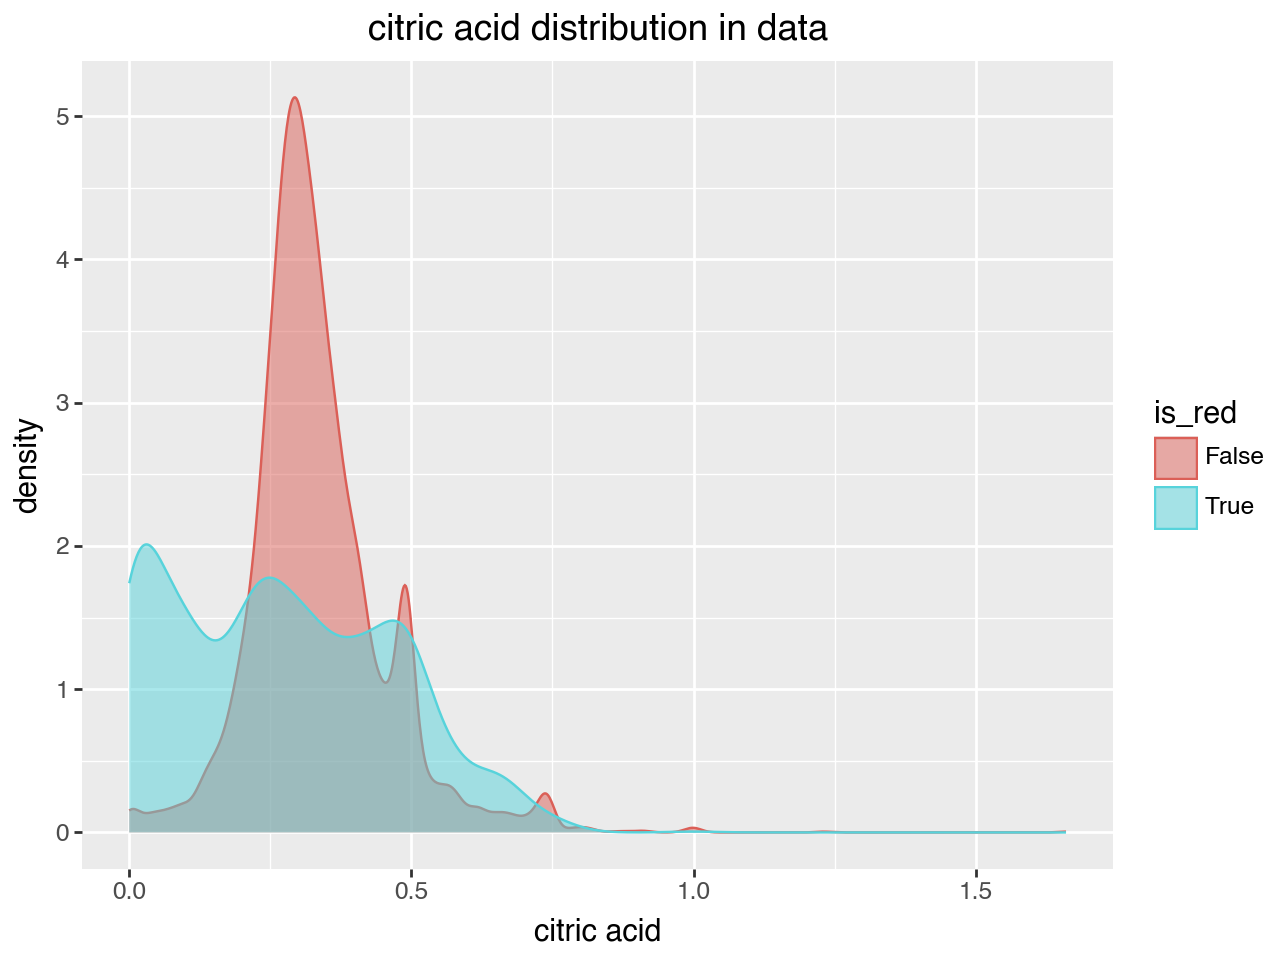

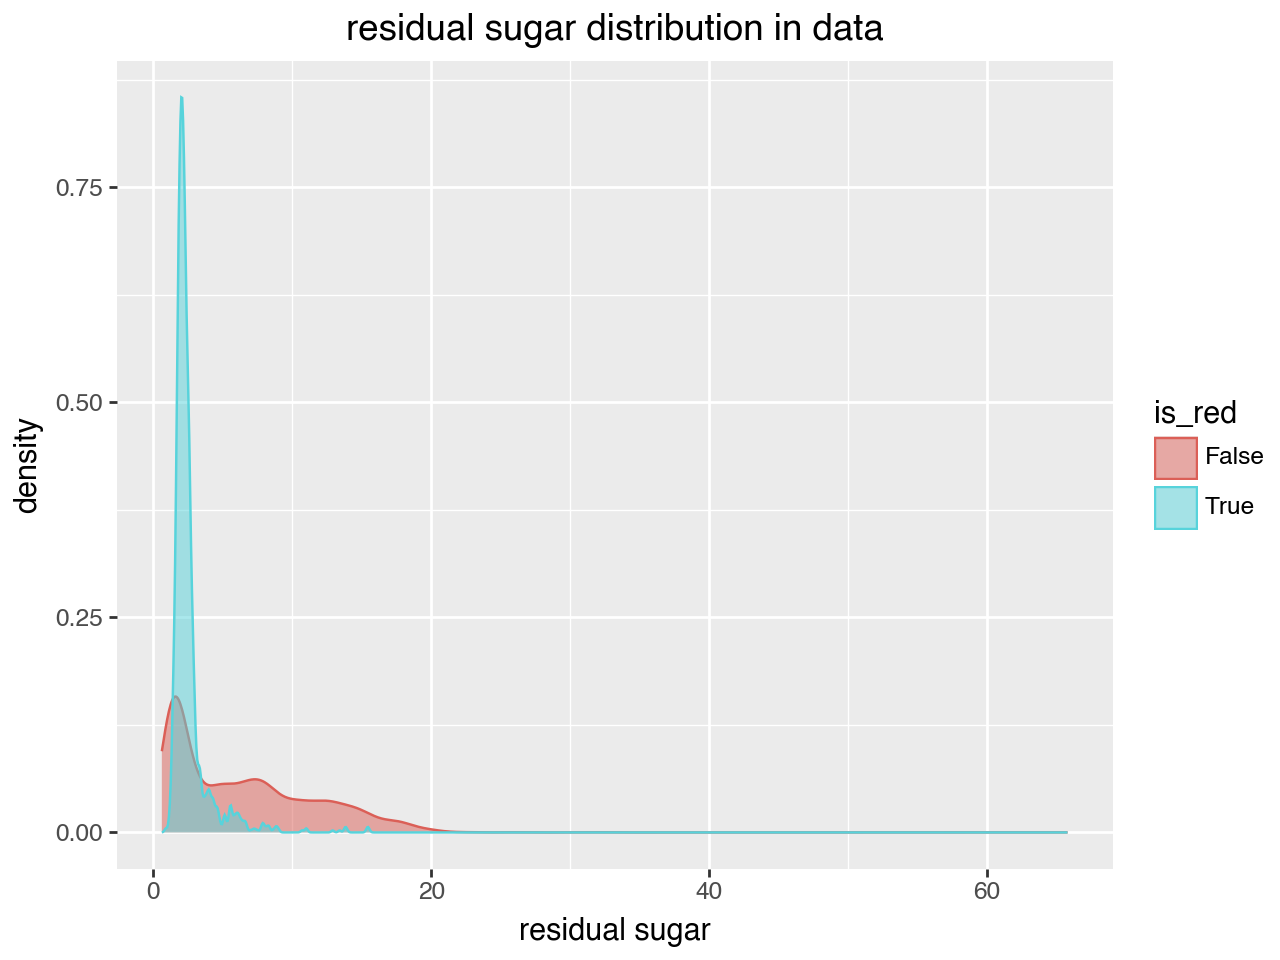

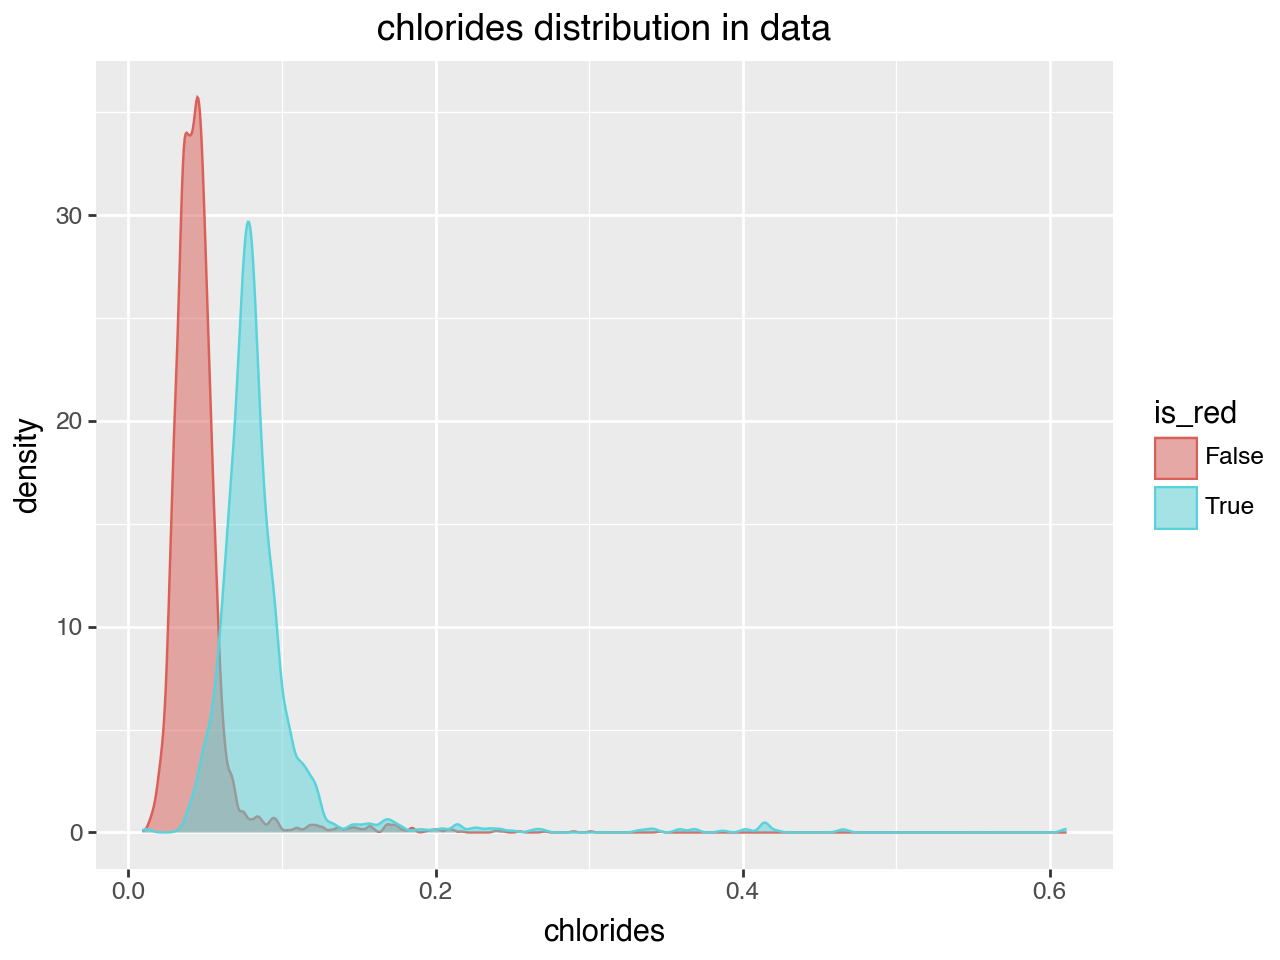

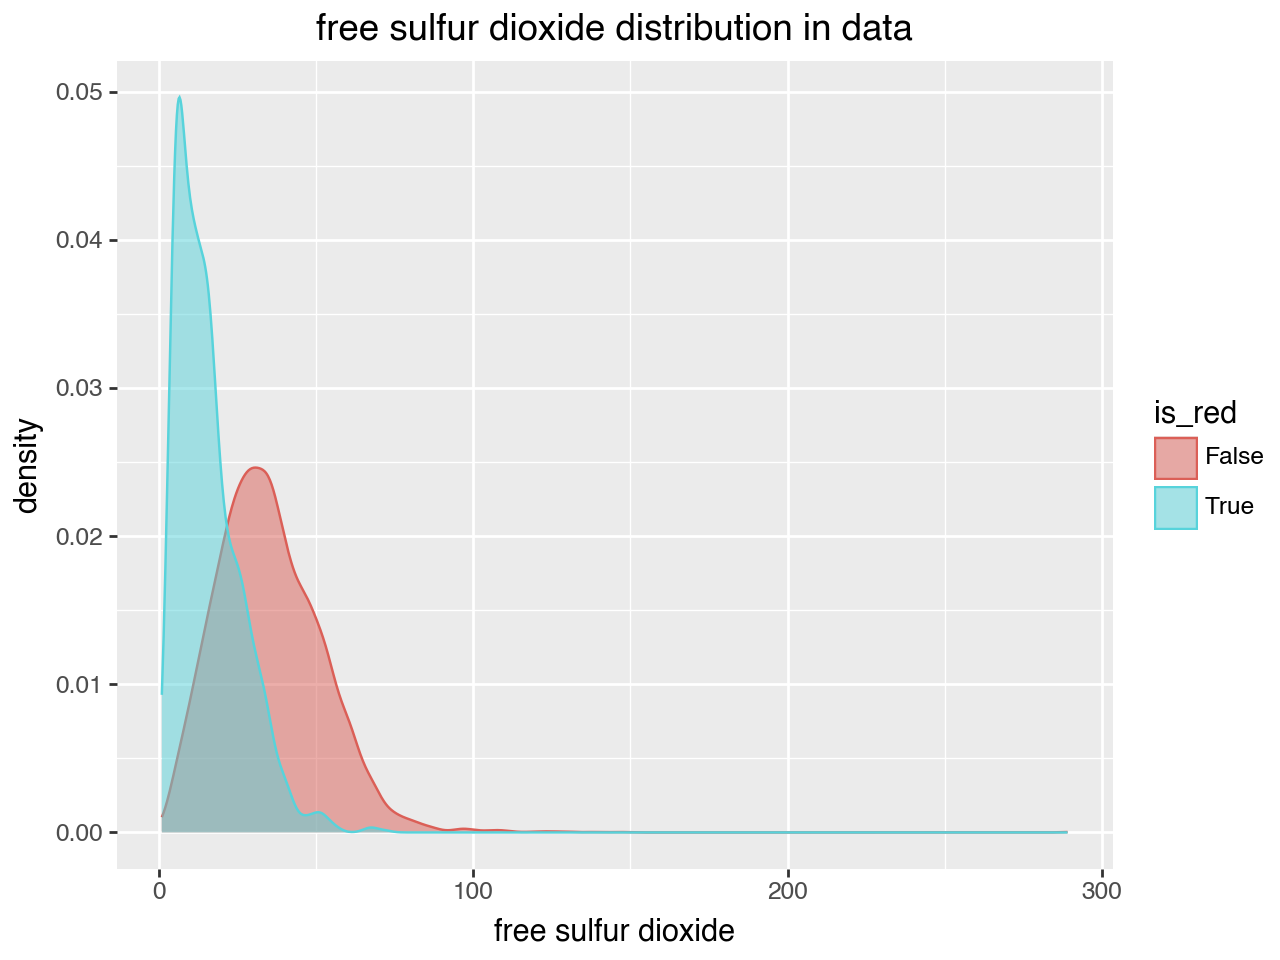

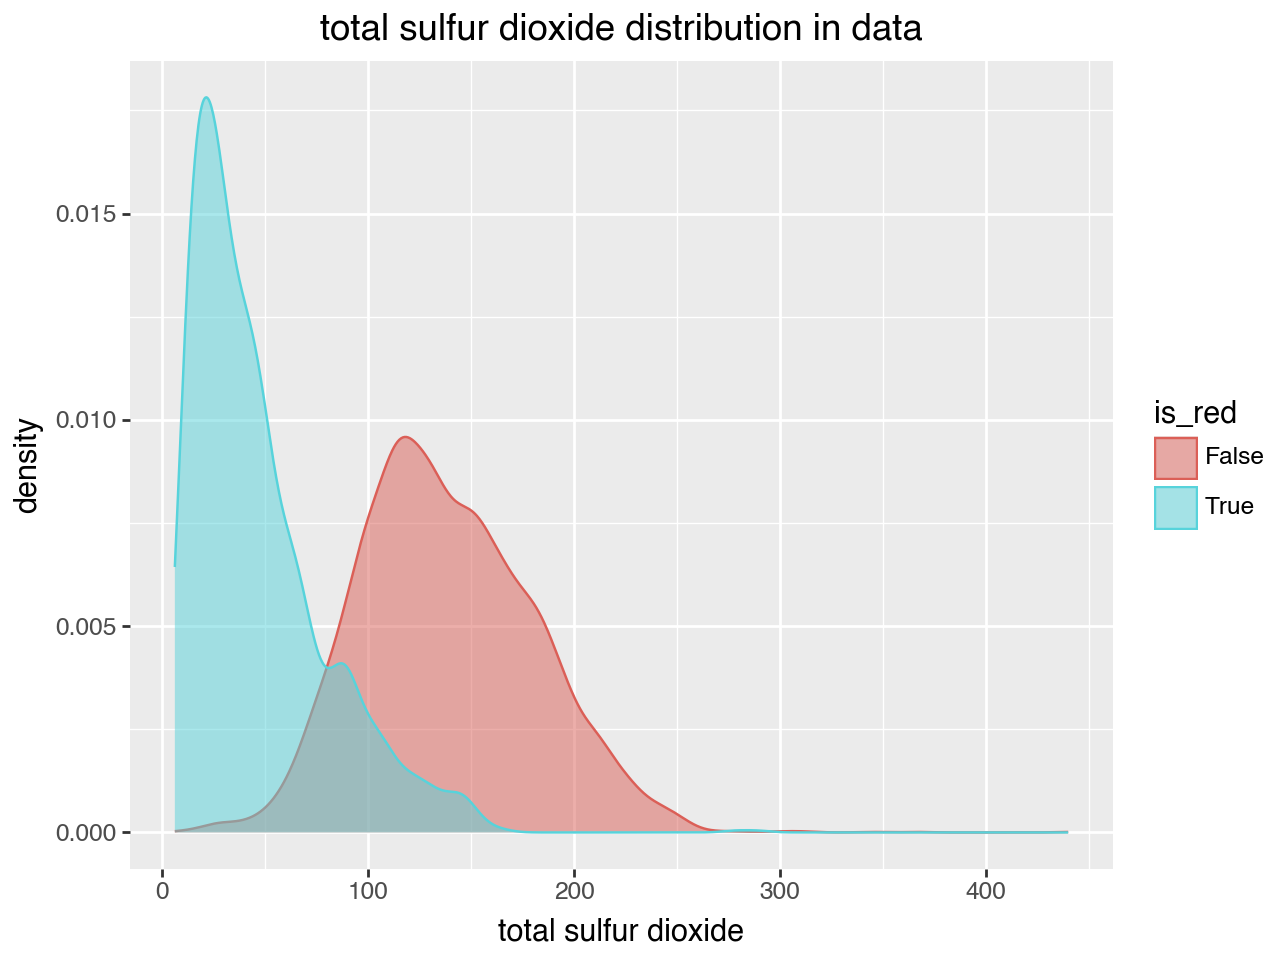

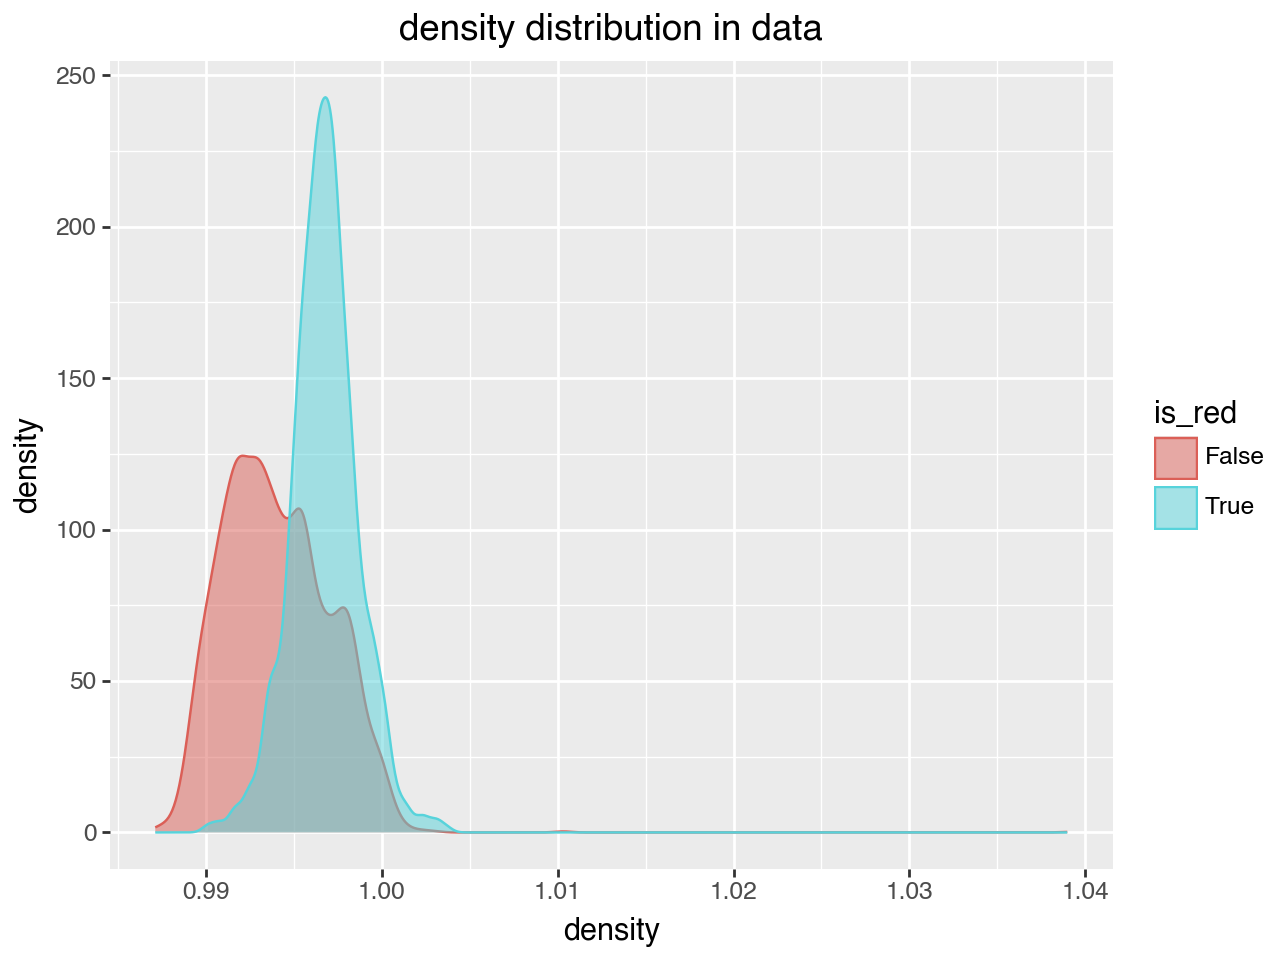

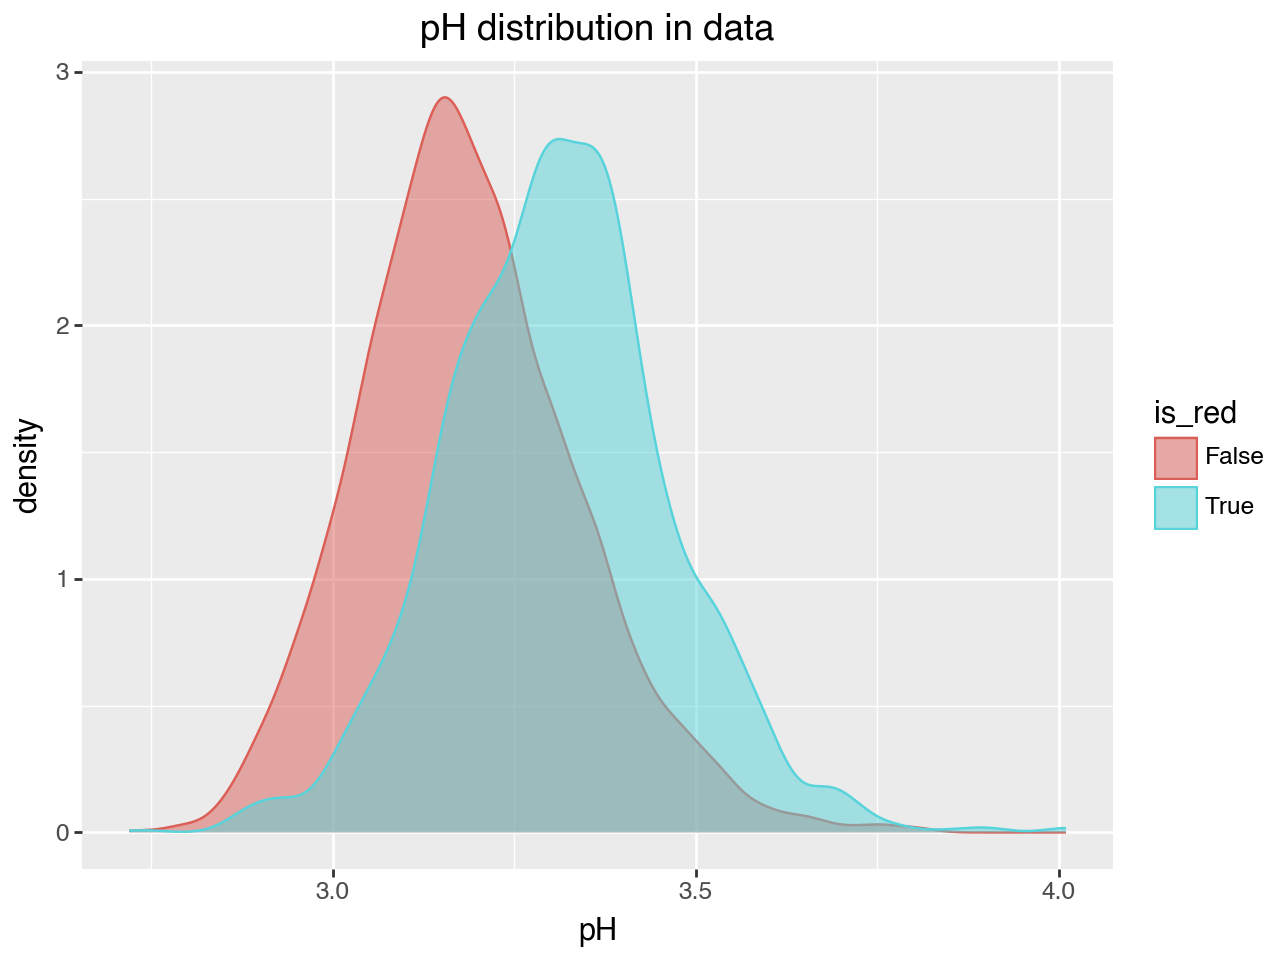

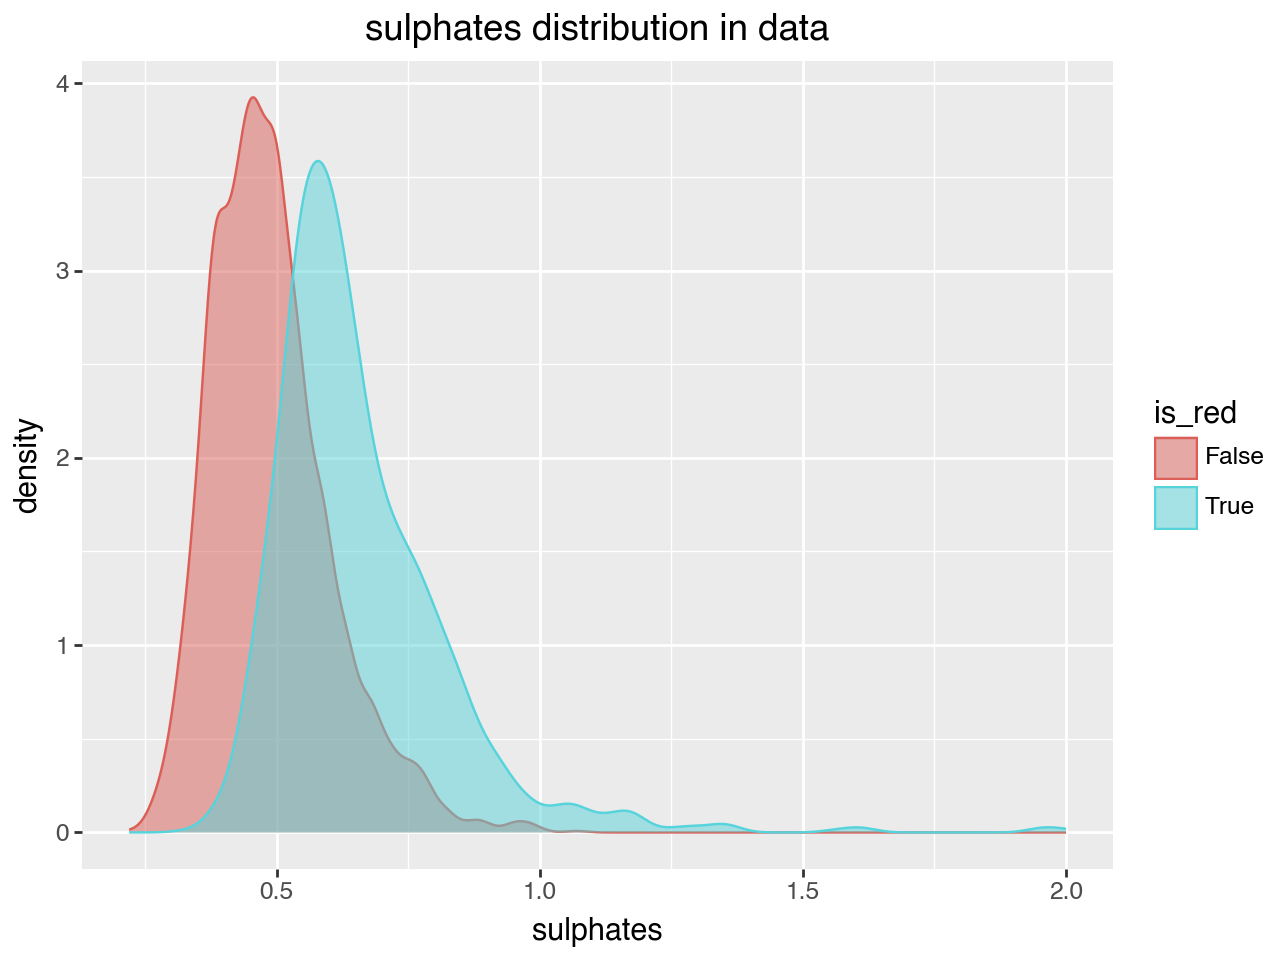

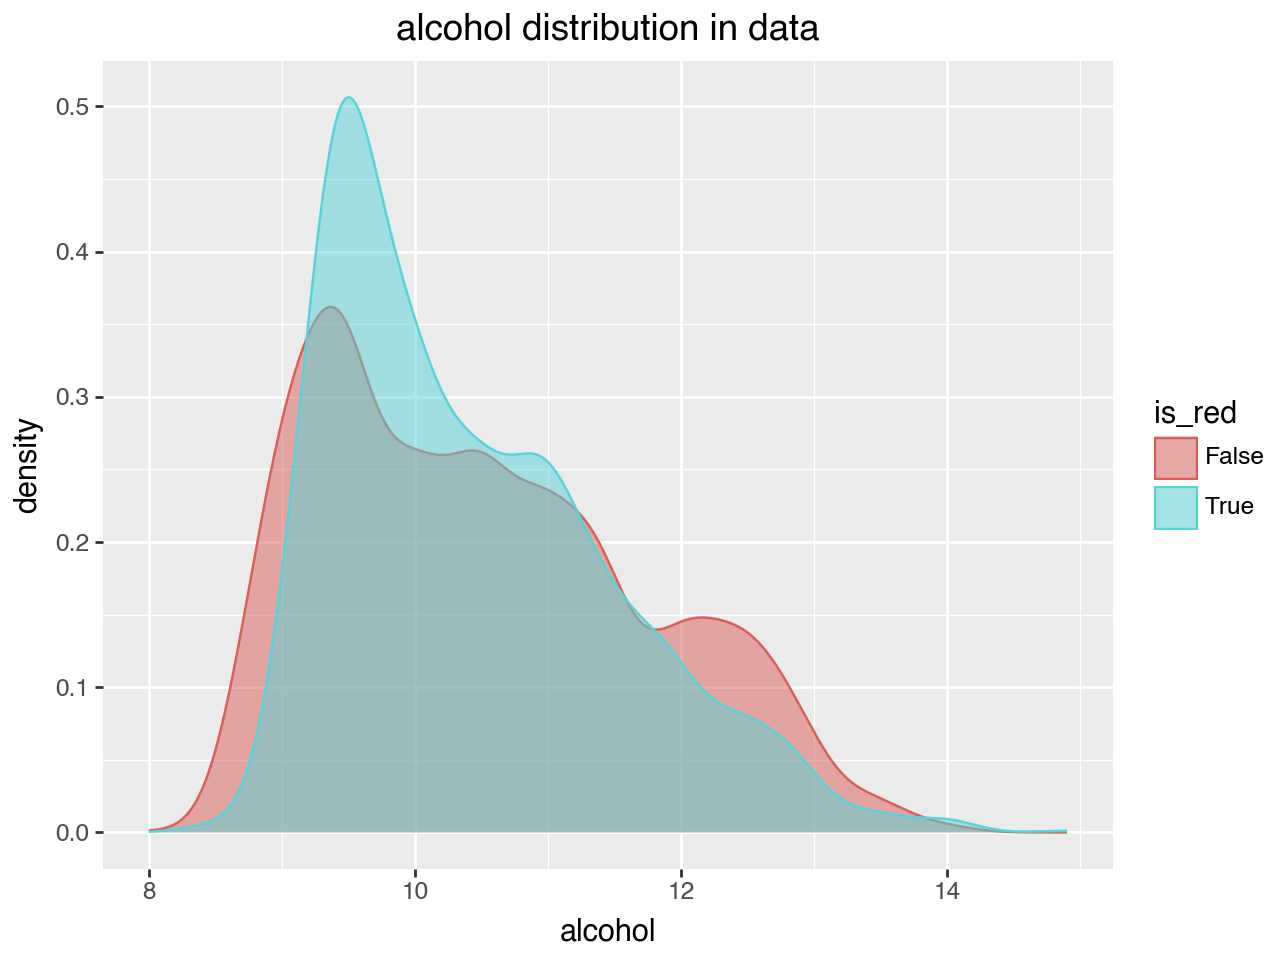

In [8]:
for c in wine_data.columns:
    if c != 'is_red':
        (
            ggplot(
                data=wine_data,
                mapping=aes(
                    x=c, 
                    color='is_red',
                    fill='is_red'
                    ),
            )
            + geom_density(alpha=0.5)
            + ggtitle(f'{c} distribution in data')
        ).show()

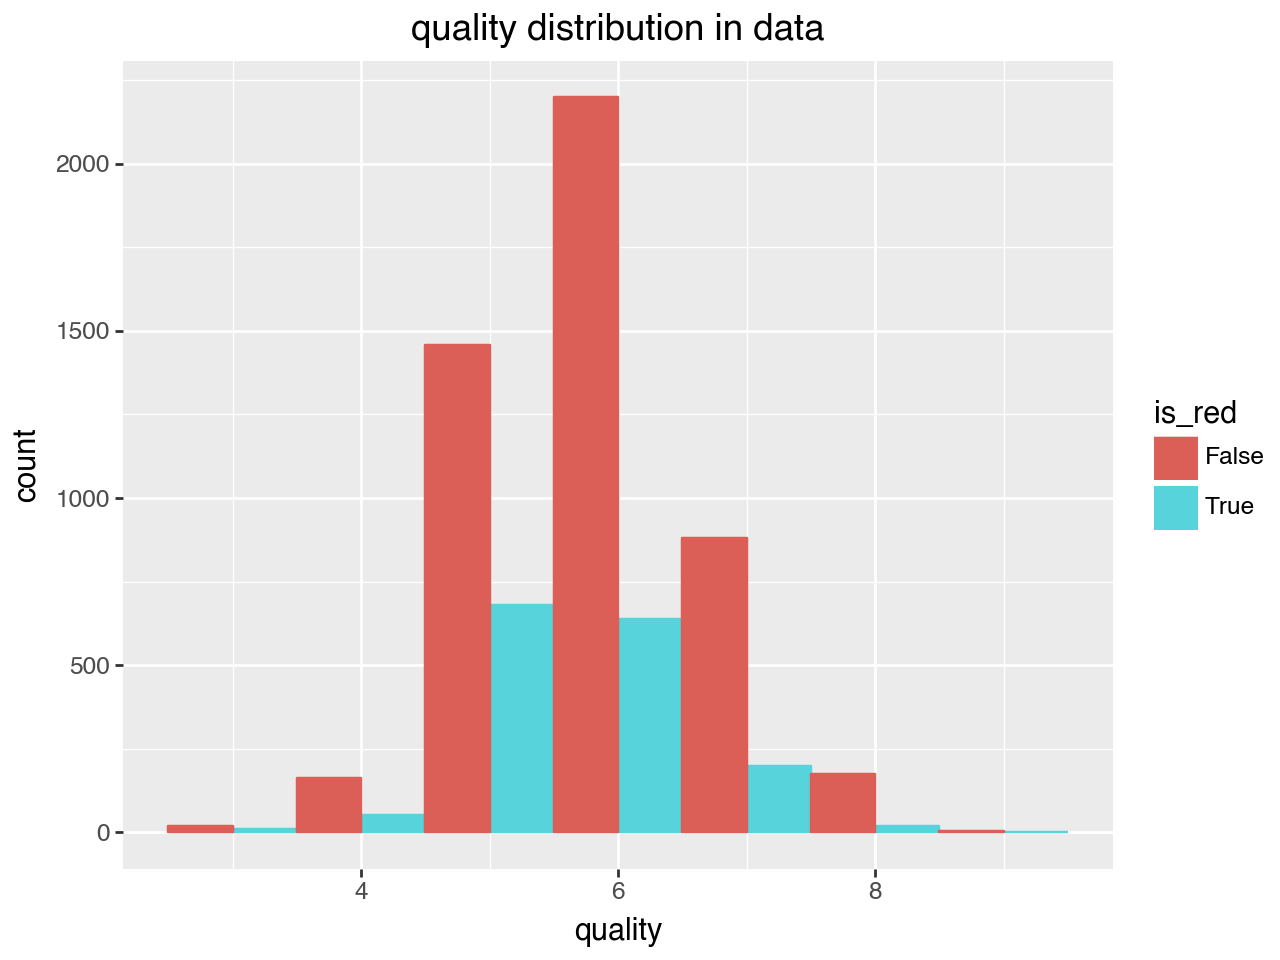

In [9]:
for c in wine_scores.columns:
    if c != 'is_red':
        (
            ggplot(
                data=wine_scores,
                mapping=aes(
                    x=c, 
                    color='is_red',
                    fill='is_red',
                    ),
            )
            + geom_histogram(position='dodge', binwidth=1)
            + ggtitle(f'{c} distribution in data')
        ).show()

In [10]:
wine_scores['quality'].value_counts()


quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [11]:
# change variables
wine_data_red = (
    wine_data
        .loc[:, [c for c in wine_data if c!='is_red']]
        .mul(np.array(wine_data['is_red'] == True), axis=0)
        .reset_index(drop=True, inplace=False)
)
wine_data_red.columns = [[f'{c} is red' for c in wine_data_red.columns]]

wine_data_white = (
    wine_data
        .loc[:, [c for c in wine_data if c!='is_red']]
        .mul(np.array(wine_data['is_red'] == False), axis=0)
        .reset_index(drop=True, inplace=False)
)
wine_data_white.columns = [[f'{c} is white' for c in wine_data_white.columns]]

wine_data_expanded = pd.concat([
    wine_data_red,
    wine_data_white,
], axis=1)
wine_data_expanded['is_red'] = np.array(wine_data['is_red'], dtype=float)

wine_data_expanded

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.00,0.0,0.000,0.0,0.0,0.00000,0.00,0.00,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.00,0.0,0.000,0.0,0.0,0.00000,0.00,0.00,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.00,0.0,0.000,0.0,0.0,0.00000,0.00,0.00,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.00,0.0,0.000,0.0,0.0,0.00000,0.00,0.00,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.00,0.0,0.000,0.0,0.0,0.00000,0.00,0.00,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,0.0,0.00,0.00,0.0,0.000,0.0,0.0,0.0000,0.00,0.00,...,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0.0
6493,0.0,0.00,0.00,0.0,0.000,0.0,0.0,0.0000,0.00,0.00,...,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0.0
6494,0.0,0.00,0.00,0.0,0.000,0.0,0.0,0.0000,0.00,0.00,...,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0.0
6495,0.0,0.00,0.00,0.0,0.000,0.0,0.0,0.0000,0.00,0.00,...,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,0.0


In [12]:
del wine_data

In [13]:
# build preference we are trying to learn
taste_model_linear = LinearRegression()
taste_model_linear.fit(wine_data_expanded, wine_scores['quality'])
beta_linear = taste_model_linear.coef_

beta_linear

array([ 2.49905527e-02, -1.08359026e+00, -1.82563948e-01,  1.63312698e-02,
       -1.87422516e+00,  4.36133331e-03, -3.26457970e-03, -1.78811638e+01,
       -4.13653144e-01,  9.16334413e-01,  2.76197699e-01,  6.55199614e-02,
       -1.86317709e+00,  2.20902007e-02,  8.14828026e-02, -2.47276537e-01,
        3.73276519e-03, -2.85747419e-04, -1.50284181e+02,  6.86343742e-01,
        6.31476473e-01,  1.93475697e-01, -1.28227634e+02])

In [14]:
# build preference we are trying to learn
taste_model_logistic = LogisticRegression(max_iter=10000, solver='newton-cholesky')
taste_model_logistic.fit(wine_data_expanded, wine_scores['quality'] >= 7)
beta_logistic = taste_model_logistic.coef_

beta_logistic

array([[ 0.10533899, -2.56169595,  0.30156635,  0.1024515 , -1.18186272,
         0.01231155, -0.01476565,  0.20159315, -0.21033076,  2.5241114 ,
         1.0267914 ,  0.04020116, -3.23152153, -0.71686893,  0.05224708,
        -1.52325805,  0.01398928, -0.00433533, -0.33574201,  1.06395565,
         1.11756589,  0.90611946,  0.23598882]])

In [15]:
wine_scores_expanded = pd.DataFrame({
    'linear_score': np.array(taste_model_linear.predict(wine_data_expanded), dtype=float),
    'logistic_score': np.array(wine_data_expanded @ taste_model_logistic.coef_[0], dtype=float),
    'quality': np.array(wine_scores['quality'], dtype=float),
    })

wine_scores_expanded

,linear_score,logistic_score,quality
0,5.032850,9.488772,5.0
1,5.137880,9.579223,5.0
2,5.209895,9.855580,5.0
3,5.693858,11.359848,6.0
4,5.032850,9.488772,5.0
...,...,...,...
6492,6.172579,13.177504,6.0
6493,5.634110,11.618862,5.0
6494,5.341921,11.167830,6.0
6495,6.571294,14.140435,7.0


In [16]:
del wine_scores

In [17]:
wine_scores_expanded['linear_score'][0]

5.032850452145453

In [18]:
s = spearmanr(
    wine_scores_expanded['linear_score'],
    wine_scores_expanded['quality'],
)
s

SignificanceResult(statistic=0.5739617371667737, pvalue=0.0)

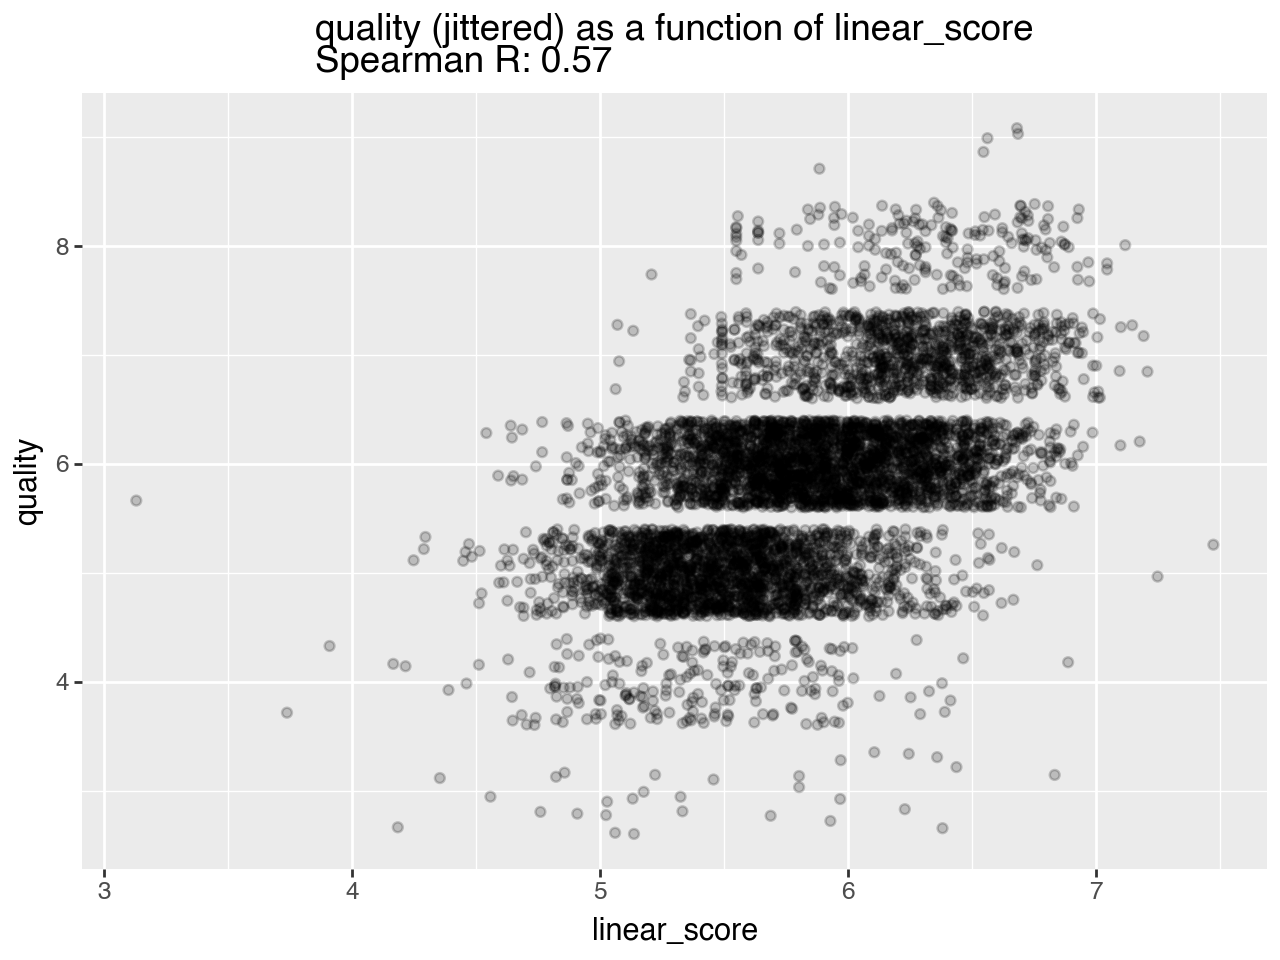

In [19]:
(
    ggplot(
        data=wine_scores_expanded,
        mapping=aes(x='linear_score', y='quality')
    )
    + geom_jitter(width=0, alpha=0.2)
    + ggtitle(f"quality (jittered) as a function of linear_score\nSpearman R: {s.statistic:.2f}")
)

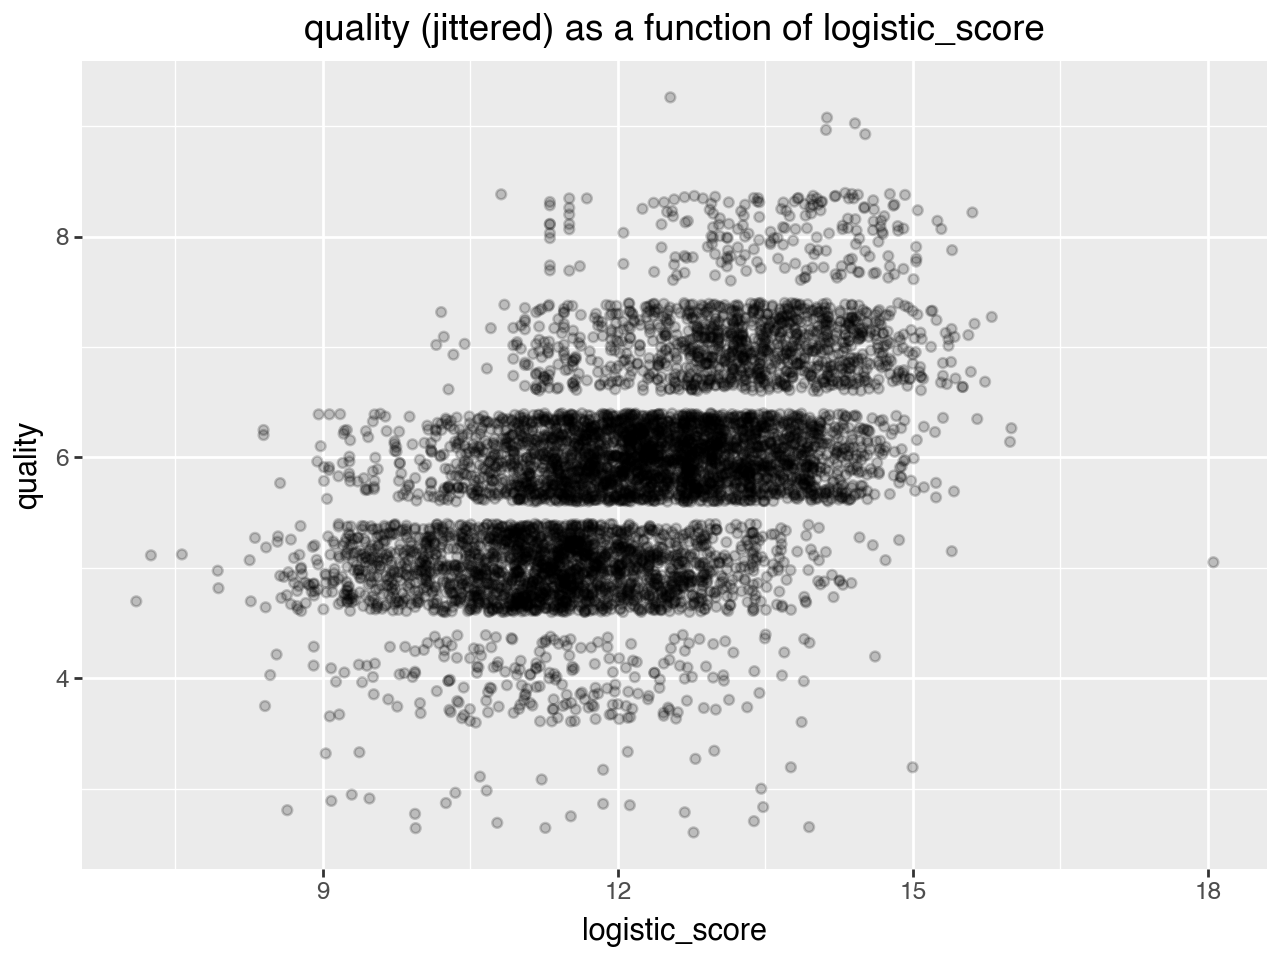

In [20]:
(
    ggplot(
        data=wine_scores_expanded,
        mapping=aes(x='logistic_score', y='quality')
    )
    + geom_jitter(width=0, alpha=0.2)
    + ggtitle("quality (jittered) as a function of logistic_score")
)

<Figure size 640x480 with 0 Axes>

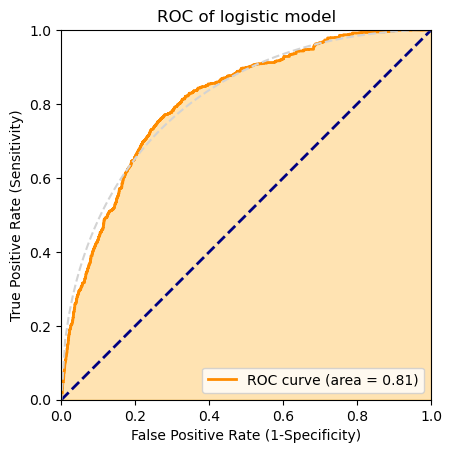

0.8085603830817558

In [21]:
plot_roc(
    prediction=wine_scores_expanded['logistic_score'],
    istrue=wine_scores_expanded['quality'] >= 7,
    ideal_line_color='lightgrey',
    title=f'ROC of logistic model',
)

In [22]:
# save 
wine_data_expanded.to_csv('uci_wine_example_features.csv', index=False)
wine_scores_expanded.to_csv('uci_wine_example_scores.csv', index=False)